Epoch 10: Current Reward -312.31, Avg Reward (Last 50) -153.83
Epoch 20: Current Reward -130.09, Avg Reward (Last 50) -157.70
Epoch 30: Current Reward -80.91, Avg Reward (Last 50) -186.07
Epoch 40: Current Reward -193.80, Avg Reward (Last 50) -189.04
Epoch 50: Current Reward -578.42, Avg Reward (Last 50) -187.74
Epoch 60: Current Reward -338.80, Avg Reward (Last 50) -191.55
Epoch 70: Current Reward -139.44, Avg Reward (Last 50) -200.27
Epoch 80: Current Reward -95.61, Avg Reward (Last 50) -198.92
Epoch 90: Current Reward -189.96, Avg Reward (Last 50) -200.02
Epoch 100: Current Reward -86.30, Avg Reward (Last 50) -223.69
Epoch 110: Current Reward -138.79, Avg Reward (Last 50) -232.82
Epoch 120: Current Reward -125.95, Avg Reward (Last 50) -211.37
Epoch 130: Current Reward -80.18, Avg Reward (Last 50) -187.18
Epoch 140: Current Reward -181.66, Avg Reward (Last 50) -181.49
Epoch 150: Current Reward -36.47, Avg Reward (Last 50) -148.11
Epoch 160: Current Reward -283.82, Avg Reward (Last 50

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


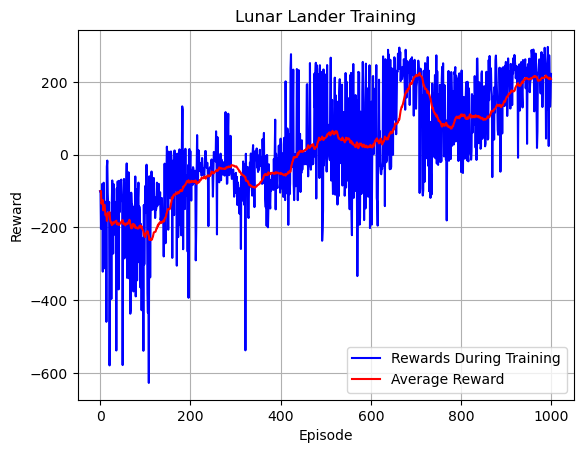

In [17]:
import torch
from torch import nn, optim
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque

env = gym.make("LunarLander-v3", continuous = True)

class OUP():
    def __init__(self, theta = 0.15, sigma = 0.2, dim = 2):
        self.dim = dim
        self.x_t = np.zeros(self.dim, dtype=np.float32)
        self.theta = -1 * theta
        self.sigma = sigma

    def reset(self):
        self.x_t = np.zeros(self.dim, dtype = np.float32)

    def __call__(self):
        dW_t = np.random.randn(self.dim)
        self.x_t += self.theta * self.x_t + self.sigma * dW_t
        return self.x_t
    
class Actor(nn.Module):
    def __init__(self):
        super(Actor,self).__init__()
        self.layer1 = nn.Linear(8,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return torch.tanh(x)
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(10,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat((state, action), dim = -1)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

oup = OUP()  

actor = Actor()
actor_optimizer = optim.Adam(actor.parameters(), lr = 1e-4)
actor_target = Actor()
actor_target.load_state_dict(actor.state_dict())

critic = Critic()
critic_optimizer = optim.Adam(critic.parameters(), lr = 1e-3)
critic_target = Critic()
critic_target.load_state_dict(critic.state_dict())

mse = nn.MSELoss()

GAMMA = 0.99
TAU = 0.001
BATCH_SIZE = 500
NUM_EPOCHS = 1000
EXPERIENCE_REPLAY_LENGTH = 500000

experience_replay = deque([], maxlen = EXPERIENCE_REPLAY_LENGTH)

total_rewards_during_training = []

for epoch in range(NUM_EPOCHS):
    state, _ = env.reset()
    oup.reset()
    individual_epoch_rewards = 0

    state = torch.tensor(state, dtype = torch.float32)
    while True:
        with torch.no_grad():
            action = actor(state) + oup()
            next_state, reward, terminated, truncated, _ = env.step(np.array(action))
            next_state = torch.tensor(next_state, dtype = torch.float32)
            experience_replay.append((state, action, reward, next_state, 1 if terminated or truncated else 0))
            state = next_state
            individual_epoch_rewards += reward

        if len(experience_replay) > 10000:
            random_experiences_array = random.sample(experience_replay, BATCH_SIZE)
            state_array, action_array, reward_array, next_state_array, done_array = zip(*random_experiences_array)

            state_array = torch.stack(state_array)
            action_array = torch.stack(action_array)
            reward_array = torch.tensor(reward_array, dtype = torch.float32)
            next_state_array = torch.stack(next_state_array)
            done_array = torch.tensor(done_array, dtype = torch.float32)
            with torch.no_grad():
                target_actions = actor_target(next_state_array).detach()
                actual_state_values = reward_array.unsqueeze(1) + GAMMA * critic_target(next_state_array, target_actions) * (1 - done_array).unsqueeze(1)
            predicted_state_values = critic(state_array, action_array)


            critic_optimizer.zero_grad()
            critic_loss = mse(predicted_state_values, actual_state_values.detach())
            critic_loss.backward()
            critic_optimizer.step()

            actor_optimizer.zero_grad()
            actor_loss = -1 * critic(state_array, actor(state_array)).mean()
            actor_loss.backward()
            actor_optimizer.step()

            target_actor_dict = {}
            for key in actor.state_dict().keys():
                target_actor_dict[key] = TAU * actor.state_dict()[key] + (1 - TAU) * actor_target.state_dict()[key]
            actor_target.load_state_dict(target_actor_dict)

            target_critic_dict = {}
            for key in critic.state_dict().keys():
                target_critic_dict[key] = TAU * critic.state_dict()[key] + (1 - TAU) * critic_target.state_dict()[key]
            critic_target.load_state_dict(target_critic_dict)
        
        if terminated or truncated:
            break

    total_rewards_during_training.append(individual_epoch_rewards)

    if epoch % 10 == 0 and epoch != 0:
        print(f"Epoch {epoch}: Current Reward {total_rewards_during_training[-1]:.2f}, Avg Reward (Last 50) {np.mean(total_rewards_during_training[max(0, epoch - 50) :]):.2f}")

plt.plot(total_rewards_during_training, color = "blue", label = "Rewards During Training")
plt.plot([np.mean(total_rewards_during_training[max(0,epoch - 50):epoch]) for epoch in range(NUM_EPOCHS)], color = "red", label = "Average Reward")
plt.grid()
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Lunar Lander Training")
plt.show()